# DATASCI W261: Machine Learning at Scale
## Assignment Week 13
Miki Seltzer (miki.seltzer@berkeley.edu)<br>
W261-2, Spring 2016<br>
Submission: 

In [1]:
# If running locally, start PySpark
import os
import sys
spark_home = os.environ.get('SPARK_HOME', None)

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.0-cdh5.5.0
      /_/

Using Python version 2.7.11 (default, Dec  6 2015 18:08:32)
SparkContext available as sc, HiveContext available as sqlContext.


# HW 13.1: Spark implementation of basic PageRank

## Write a basic Spark implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input.
- Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).
- In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.

In [20]:
# If local:
# Use the test data set and put in HDFS to read using Spark
!hdfs dfs -copyFromLocal PageRank-test.txt /user/miki/week13/

In [1]:
# If EMR:
!aws s3 cp PageRank-test.txt s3://ms-w261-hw13/PageRank-test.txt

upload: ./PageRank-test.txt to s3://ms-w261-hw13/PageRank-test.txt


### Initialize data set
- Some nodes are dangling, and will not appear as keys in original file
- Initialize all nodes to have uniformly distributed PageRank

In [1]:
# We need this function to merge dictionaries for each key
def mergeDicts(x, y):
    x.update(y)
    return x

#########
# This function initializes the data into a PageRank-iterable form
# Input:
#  - filename: string, contents formatted as follows:
#    node \t {neighbor1:1, neighbor2:1, ...}
#  - printDebug: print debugging string?
# 
# Output:
#  - writes initialized data to file appended with _initialized formatted as follows:
#    test.txt --> test_initialized
#    (node, [{neighbors}, PageRank])
#  - returns number of nodes in graph
#########

def initializeData(filename, printDebug=False):
    # Read test data
    lines = sc.textFile(filename, use_unicode=False)

    # Map lines to get key-value pairs (key = string, value = dictionary of neighbors)
    data = lines.map(lambda x: [x.split('\t')[0], eval(x.split('\t')[1])])


    # 1. flatMap: expand dictionary of neighbors to get all nodes
    # 2. union: union with previous data to maintain original graph
    # 3. aggregateByKey: to merge empty dictionaries and neighbor dictionaries
    # 4. map: to get into PageRank format of (node, [neighbors, PageRank])
    expandedData = (data
                    .flatMap(lambda x: [[node, {}] for node in x[1]])
                    .union(data)
                    .reduceByKey(lambda x, y: mergeDicts(x, y))
                    .map(lambda x: (x[0], [x[1], 1.0]))
                    .cache()
                   )

    # Broadcast the number of nodes
    numNodes = sc.broadcast(expandedData.count())

    # map to normalize expandedData with the number of nodes (PageRanks should sum to 1!)
    initializedData = (expandedData
                      .map(lambda x: (x[0], [x[1][0], x[1][1] / numNodes.value]))
                      .cache()
                      )
    
    # Write initializedData to HDFS
    initializedFilename = filename.replace('.txt', '_initialized')
    initializedData.saveAsTextFile(initializedFilename)

    if printDebug:
        # Validate initializedData
        print 'Format of initializedData'
        print '(node, [{neighbors}, PageRank])'
        print '\nExamples'
        for node in initializedData.take(2):
            print node

        # Validate that PageRanks sum to 1
        print '\nValidate that sum of PageRanks is 1'
        print initializedData.map(lambda x: x[1][1]).sum()


In [4]:
# Run function on test data
initializeData('/user/miki/week13/PageRank-test.txt', printDebug=True)

Format of initializedData
(node, [{neighbors}, PageRank])

Examples
('A', [{}, 0.09090909090909091])
('I', [{'B': 1, 'E': 1}, 0.09090909090909091])

Validate that sum of PageRanks is 1
1.0


###  Iterate PageRank algorithm
We need to do the following:
- Distribute a node's PageRank to its neighbors
- Distribute the mass of dangling nodes and account for teleporting

In [2]:
import time

# Function to cache and partition RDDs
# Adapted from http://stackoverflow.com/questions/31659404/spark-iteration-time-increasing-exponentially-when-using-join
def procRDD(rdd, cache=True, part=False, hashp=False, npart=16):
    rdd = rdd if not part else rdd.repartition(npart)
    rdd = rdd if not hashp else rdd.partitionBy(npart)
    return rdd if not cache else rdd.cache()

# Function to distribute PageRank equally to neighbors
def distributePR(node):
    # node is formatted (node, [{neighbors}, PageRank])
    neighbors = node[1][0]
    PR = node[1][1]
    
    # If there are neighbors, distribute PageRank
    if len(neighbors) > 0:
        return [(neighbor, PR / len(neighbors)) for neighbor in neighbors]
    
    # Else, collect PageRank into dangling mass
    else:
        return [('*dangling', PR)]

# Function to calculate final PageRank with teleportation and dangling mass
def finalPageRank(node, m, a, n):
    # node is formatted (node, [{neighbors}, PageRank])
    nodeName = node[0]
    neighbors = node[1][0]
    if node[1][1]:
        PR = node[1][1]
    else:
        PR = 0
    
    # Calculate new PageRank
    newPageRank = a / n + (1 - a) * (m / n + PR) 
    
    return (nodeName, [neighbors, newPageRank])

    
#########
# This function iterates the initialized data for a set number of iterations
# Input:
#  - filename of initialized data from above function
#  - iterations: number of iterations to run PageRank algorithm, default 1
#  - a (alpha): teleportation factor, default 0.15
# 
# Output:
#  - writes data to file appended with _final formatted as follows:
#    test_initialized --> test_final
#    (node, [{neighbors}, PageRank])
#########

def iteratePageRankOptimized(filename, outfile, iterations=1, alpha=0.15, printFinal=False, 
                             cache=True, part=True, hashp=True, npart=16):

    times = []
    
    # Read in and parse file
    # 1. textFile: read in data from text file
    # 2. map: evaluate each line to get it into tuple form
    data = (sc
            .textFile(filename)
            .map(lambda x: eval(x))
            .cache()
           )

    # Graph structure only
    # 1. map: Include only the node and the graph structure
    graph = procRDD(data
                    .map(lambda x: (x[0], x[1][0])),
                    cache, part, hashp, npart
                   )
    
    # Broadcast variables
    numNodes = sc.broadcast(data.count())
    a = sc.broadcast(alpha)

    print 'Progress: ',
    
    for i in range(iterations):
        time1 = time.time()

        # Distribute PageRank
        # 1. flatMap: distribute PR to each neighbor node
        # 2. reduceByKey: sum PR for each node
        # 3. fullOuterJoin: join to maintain graph structure. Need fullOuter because:
        #    - Dangling mass is not in graph structure
        #    - Nodes with no incoming links are only in graph structure
        # 4. map: reverse joined values to maintain format of initialized data
        newPR = procRDD(data
                        .flatMap(distributePR)
                        .reduceByKey(lambda x, y: x + y)
                        .fullOuterJoin(graph, npart)
                        .map(lambda x: (x[0], [x[1][1], x[1][0]])),
                        cache, part, hashp, npart
                       )

        # Collect dangling mass
        # 1. filter: only keep dangling mass key
        # 2. map: identify mass (discard dummy node name and graph structure)
        # 3. sum: accumulate all mass
        dangling = (newPR
                    .filter(lambda x: x[0] == '*dangling')
                    .map(lambda x: x[1][1])
                    .sum()
                   )

        # Distribute dangling mass to all nodes and account for teleportation
        data = procRDD(newPR
                       .filter(lambda x: x[0] != '*dangling')
                       .map(lambda x: finalPageRank(x, dangling, a.value, numNodes.value)),
                       cache, part, hashp, npart
                      )

        time2 = time.time()
        times.append(time2 - time1)
        
        print i + 1,
        
    if printFinal:
        print '\n\nFinal PageRanks:'
        for node in data.sortByKey().collect():
            print '{:4s}{:.3f}'.format(node[0], node[1][1])
    
    # Save to text file
    data.saveAsTextFile(outfile)
    
    return times

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotTimes(t):
    plt.scatter(range(1, len(t) + 1), t, marker='o')
    plt.plot(range(1, len(t) + 1), t)
    plt.title('Length of time per iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Time (sec)')
    plt.xlim(0,len(t) + 1)
    plt.grid(True)

Progress:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

Final PageRanks:
A   0.033
B   0.384
C   0.344
D   0.039
E   0.081
F   0.039
G   0.016
H   0.016
I   0.016
J   0.016
K   0.016

30 iterations took 102 seconds.


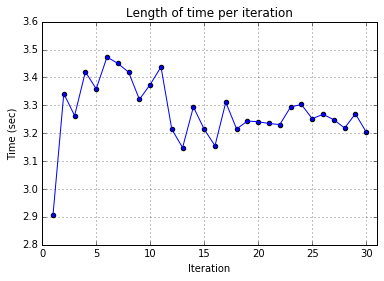

In [12]:
# Run locally
iter = 30
startTime = time.time()
plotTimes(iteratePageRankOptimized('/user/miki/week13/PageRank-test_initialized', 
                                   '/user/miki/week13/PageRank-test_final',
                                   iterations=iter, alpha=0.15, printFinal=True))
endTime = time.time()

print '\n{:d} iterations took {:d} seconds.'.format(iter, int(endTime - startTime))

### EMR configurations
- 1 master node: r3.xlarge
- 5 worker nodes: r3.xlarge

Initializing...

Iterating...
Progress:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
30 iterations took 78 seconds.


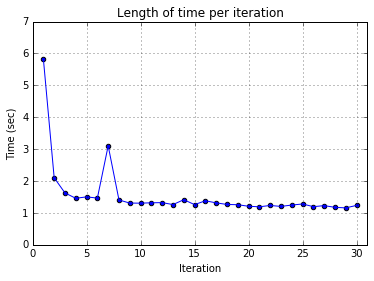

In [5]:
############
# Run on EMR
############

# Initialize data
print "Initializing..."
initializeData('s3://ms-w261-hw13/PageRank-test.txt', printDebug=False)

# Iterate over data
iter = 30
print '\nIterating...'
startTime = time.time()
plotTimes(iteratePageRankOptimized('s3://ms-w261-hw13/PageRank-test_initialized', 
                                   's3://ms-w261-hw13/PageRank-test_final2',
                                   iterations=iter, alpha=0.15, printFinal=False, npart=16))
endTime = time.time()
print '\n{:d} iterations took {:d} seconds.'.format(iter, int(endTime - startTime))

# HW 13.2: Applying PageRank to the Wikipedia hyperlinks network
### Run your Spark PageRank implementation on the Wikipedia dataset for 10 and 50 iterations with damping = 0.85.

In [13]:
# Copy Wikipedia data to S3 bucket
!aws s3 cp s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt s3://ms-w261-hw13/wikipedia.txt

copy: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt to s3://ms-w261-hw13/wikipedia.txt


In [6]:
# Initialize data
print "Initializing..."
startTime = time.time()
initializeData('s3://ms-w261-hw13/wikipedia.txt', printDebug=True)
endTime = time.time()
print 'Initializing took {:d} seconds.'.format(int(endTime - startTime))

Initializing...
Format of initializedData
(node, [{neighbors}, PageRank])

Examples
('3878982', [{'13284863': 1, '4429879': 1, '14732081': 1, '4442056': 1, '15168171': 1, '14998575': 1, '14618222': 1, '14539153': 1, '8488434': 1, '14280256': 1, '15063801': 1, '14108550': 1, '14923757': 1, '6144002': 1, '14994586': 1, '14769768': 1, '10743112': 1, '14899549': 1, '15168141': 1, '578382': 1, '15014506': 1, '14136631': 1, '14539186': 1, '13320784': 2, '2396749': 1, '14552925': 1, '8115742': 1, '14855076': 1, '15086453': 1, '1051386': 1, '14923747': 1, '14779312': 1, '14675217': 1, '10156814': 1, '14539049': 1, '14539124': 1}, 6.582291778908455e-08])
('14899290', [{}, 6.582291778908455e-08])

Validate that sum of PageRanks is 1
1.00000000001
Initializing took 581 seconds.



Iterating...
Progress:  1 2 3 4 5 6 7 8 9 10 
10 iterations took 1830 seconds.


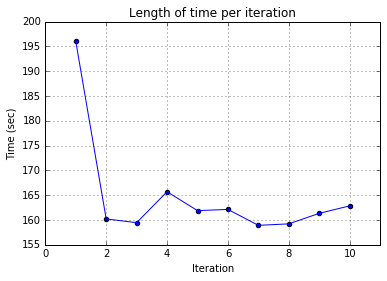

In [9]:
# Iterate over data 10 times
iter = 10
print '\nIterating...'
startTime = time.time()
plotTimes(iteratePageRankOptimized('s3://ms-w261-hw13/wikipedia_initialized', 
                                   's3://ms-w261-hw13/wikipedia_final_1_200part',
                                   iterations=iter, alpha=0.15, printFinal=False, npart=200))
endTime = time.time()
print '\n{:d} iterations took {:d} seconds.'.format(iter, int(endTime - startTime))


Iterating...
Progress:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 
40 iterations took 6657 seconds.


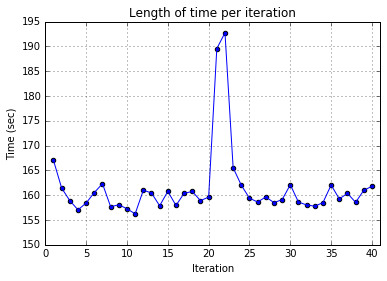

In [4]:
# Iterate over data 40 additional times
iter = 40
print '\nIterating...'
startTime = time.time()
plotTimes(iteratePageRankOptimized('s3://ms-w261-hw13/wikipedia_final_1_200part', 
                                   's3://ms-w261-hw13/wikipedia_final_50_200part',
                                   iterations=iter, alpha=0.15, printFinal=False, npart=200))
endTime = time.time()
print '\n{:d} iterations took {:d} seconds.'.format(iter, int(endTime - startTime))

In [13]:
# Find top 100 from 10 iteration set
infile = 's3://ms-w261-hw13/wikipedia_final_1_200part'

top = 100

topAfter10 = (sc
              .textFile(infile)
              .map(lambda x: eval(x))
              .map(lambda x: [x[1][1], x[0]])
              .sortByKey(ascending=False)
              .take(top)
             )

In [15]:
# Find top 100 from 50 iteration set
infile = 's3://ms-w261-hw13/wikipedia_final_50_200part'

topAfter50 = (sc
              .textFile(infile)
              .map(lambda x: eval(x))
              .map(lambda x: [x[1][1], x[0]])
              .sortByKey(ascending=False)
              .take(top)
             )

In [16]:
sc.parallelize(topAfter10).saveAsTextFile('s3://ms-w261-hw13/wikipedia_top100_10')
sc.parallelize(topAfter50).saveAsTextFile('s3://ms-w261-hw13/wikipedia_top100_50')

In [1]:
# Join with page names for reading ease

# !aws s3 cp s3://ucb-mids-mls-networks/wikipedia/indices.txt s3://ms-w261-hw13/wikipedia_indices.txt

names = (sc
         .textFile('s3://ms-w261-hw13/wikipedia_indices.txt', use_unicode=False)
         .map(lambda x: x.split('\t'))
         .map(lambda x: [x[1], x[0]])
         .cache()
        )

print names.first()

['1', '! $var = &quot;&quot;']


In [20]:
topAfter10Names = (sc
                   .textFile('s3://ms-w261-hw13/wikipedia_top100_10', use_unicode=False)
                   .map(lambda x: eval(x))
                   .map(lambda x: [x[1], x[0]])
                   .join(names)
                   .map(lambda x: [x[0], x[1][1], x[1][0]])
                   .takeOrdered(100, key=lambda x: -x[2])
                  )

In [22]:
topAfter50Names = (sc
                   .textFile('s3://ms-w261-hw13/wikipedia_top100_50', use_unicode=False)
                   .map(lambda x: eval(x))
                   .map(lambda x: [x[1], x[0]])
                   .join(names)
                   .map(lambda x: [x[0], x[1][1], x[1][0]])
                   .takeOrdered(100, key=lambda x: -x[2])
                  )

### Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

The top pages are nearly identical between the 10 iteration and 50 iteration runs. The only difference is that 'New York' and 'Central European Summer Time' have switched positions. The PageRank values are nearly identical as well -- the page with the maximum change was 'The New York Times' (0.087%).

In [79]:
import numpy as np

after10 = np.array(topAfter10Names)
namesAfter10 = after10[:, 1]
pagerankAfter10 = after10[:, 2].astype('float')

after50 = np.array(topAfter50Names)
namesAfter50 = after50[:, 1]
pagerankAfter50 = after50[:, 2].astype('float')

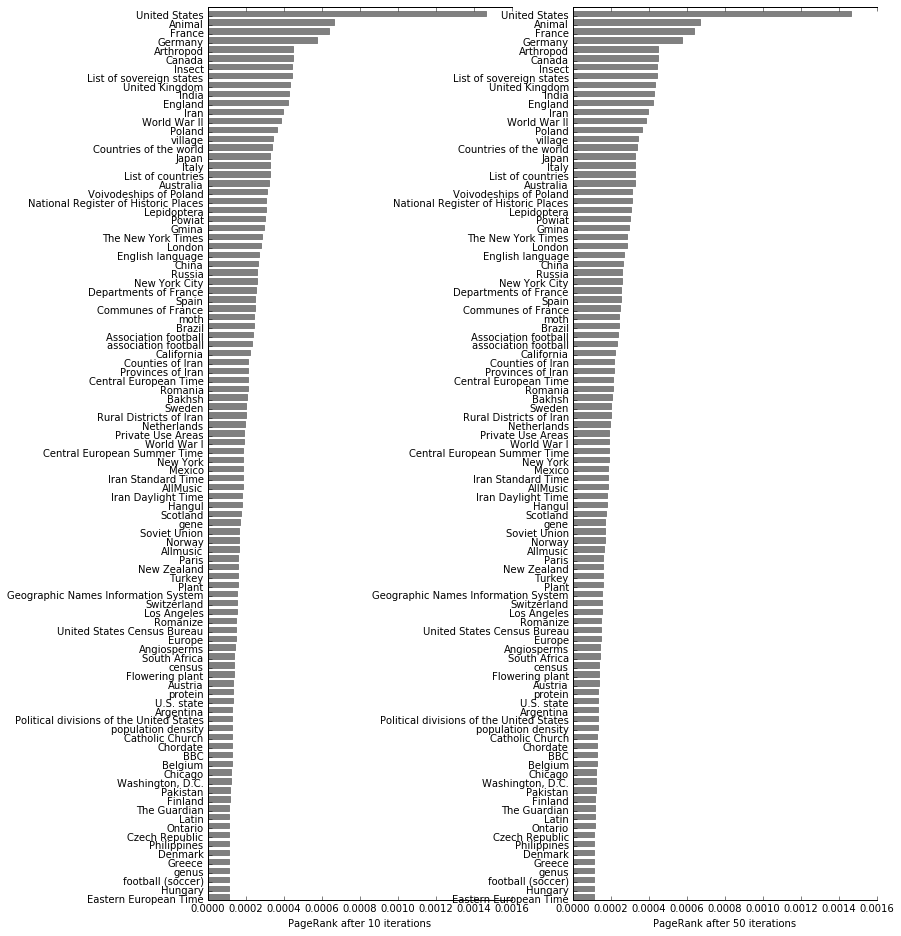

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotPageRanks(rows, cols, idx, y, x, title):
    ax = plt.subplot(rows, cols, idx)
    ax.barh(y, x, height=0.6, tick_label=namesAfter10, color='grey', edgecolor='grey')
    ax.spines['right'].set_visible(False)
    ax.get_yaxis().tick_left()
    plt.xlabel(title)
    
y = range(100)
y.reverse()

plt.figure(figsize=(12, 16))
plotPageRanks(1, 2, 1, y, pagerankAfter10, 'PageRank after 10 iterations')
plotPageRanks(1, 2, 2, y, pagerankAfter50, 'PageRank after 50 iterations')

In [72]:
print '{:<6s}{:50s}{:50s}'.format('same?', 'After 50 iterations', 'After 10 iterations')
print '-'*106
for i in range(len(namesAfter50)):
    print '{:<6b}{:50s}{:50s}'.format(namesAfter50[i] == namesAfter10[i], namesAfter50[i], namesAfter10[i])

same? After 50 iterations                               After 10 iterations                               
----------------------------------------------------------------------------------------------------------
1     United States                                     United States                                     
1     Animal                                            Animal                                            
1     France                                            France                                            
1     Germany                                           Germany                                           
1     Arthropod                                         Arthropod                                         
1     Canada                                            Canada                                            
1     Insect                                            Insect                                            
1     List of sovereign states       

In [122]:
# NumPy doesn't have joins, so find a way to join PageRanks after 10 and 50 iterations
tempOrder = []
for i in range(len(namesAfter50)):
    tempOrder.append(pagerankAfter10[np.where(namesAfter10 == namesAfter50[i])[0][0]])
    
# Get maximum percent change in PageRank
allPageRanks = np.column_stack((pagerankAfter50, tempOrder))
maxChange = np.max(np.divide(allPageRanks[:,0], allPageRanks[:,1]) - 1)
maxName = namesAfter50[np.where(np.divide(allPageRanks[:,0], allPageRanks[:,1]) - 1 == maxChange)[0][0]]
print '{} changed {:.3%}'.format(maxName, maxChange)

The New York Times changed 0.087%
